# A0201613Y Chong Zhen Jie

# Full code for MA5232: Project 2 Question 3
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Set parameters and initial conditions

In [2]:
m = [1., 2.]
kB = 1.
colfreq = [1., 2., 3/2]
n = [2., 1.]

u_init = [np.array([-1.,0,0]), np.array([1.,0,0])]
T_init = [1., 2.]

def two_norm_sq(vector):
    """
    Args:
    ===
    v: any vector
    
    Output:
    ===
    Intermediate function to return the squared value of a vector two-norm.
    """
    return np.linalg.norm(vector)**2

def f_init(sp, u_init=u_init, T_init=T_init, n=n, m=m, kB=kB):
    """
    Args:
    ===
    sp: i-th species
    u_init: initial mean velocity
    T_init: initial temperature
    n: number density
    m: mass
    kB: Boltzmann's constant
    v: velocity
    
    Output:
    ===
    Computes initial distribution function for species: sp = 1, 2. Returns value at given velocity v.
    """
    if sp not in [1,2]:
        print("ERROR: Invalid species index.")
    
    def compute_f_init(v):
        return n[sp-1] * ((m[sp-1] / (2*np.pi*kB*T_init[sp-1]))**1.5) * np.exp(-(m[sp-1]*two_norm_sq(v-u_init[sp-1])) / (2*kB*T_init[sp-1]))
    
    return compute_f_init

# Computing macroscopic quantities using Monte Carlo integral

In [3]:
# Set parameters for Monte Carlo integration

a = -5
b = 5
num = 10**5
seed = 5232

np.random.seed(seed)
v_list = np.random.uniform(a,b, (num, 3))

In [4]:
# Define function for Monte Carlo integration

def mc_int(sp, a=a, b=b, fn=f_init, v_list=v_list, num=num, u_init=u_init):
    """
    Args:
    ===
    sp: i-th species
    a: lower limit
    b: upper limit
    fn: distribution function
    v_list: velocity grid
    num: number of velocities in v_list
    u_init: initial mean velocity to compute internal energy
    
    Output:
    ===
    Computes Monte Carlo integral. Returns macroscopic quantities density, momentum, internal energy, energy.
    """
    function = fn(sp)
    f_list = []
    mmt_list = []
    Ei_list = []
    E_list = []
    
    for v in v_list:
        # Compute f(v)
        f = function(v)
        f_list.append(f)
        # Compute v*f(v)
        mmt_list.append(v*f)
        # Compute 0.5(|v-u|**2)f(v)
        Ei_list.append(0.5 * two_norm_sq(v - u_init[sp-1]) * f)
        # Compute 0.5(|v|**2)f(v)
        E_list.append(0.5 * two_norm_sq(v) * f)   
    
    # Compute numerical values of the respective integrals, multiplied by the mass to get the macroscopic quantities
    compute_mqty = lambda x: ((b-a)**3) * (np.sum(x, axis=0) / num) * m[sp-1]
    rho = compute_mqty(f_list)
    mmt = compute_mqty(mmt_list)
    Ei = compute_mqty(Ei_list)
    E = compute_mqty(E_list)
    
    print(f"density of species {sp}: {rho}")
    print(f"momentum of species {sp}: {mmt}")
    print(f"internal energy of species {sp}: {Ei}")
    print(f"energy of species {sp}: {E}")
    return rho, mmt, Ei, E

In [5]:
# Compute macroscopic quantities

rho1, mmt1, Ei_1, E1 = mc_int(1)
rho2, mmt2, Ei_2, E2 = mc_int(2)

density of species 1: 2.029559214033467
momentum of species 1: [-2.06501999  0.00669451  0.00647429]
internal energy of species 1: 2.984263396066316
energy of species 1: 4.03450377781187
density of species 2: 1.9631638895279249
momentum of species 2: [ 1.94806889 -0.00314541  0.02055484]
internal energy of species 2: 2.968657875293191
energy of species 2: 3.9351448204068307


In [6]:
# Compute other macroscopic quantities

u1 = mmt1 / rho1
T1 = (2 * m[0] * Ei_1) / (3 * kB * rho1)

u2 = mmt2 / rho2
T2 = (2 * m[1] * Ei_2) / (3 * kB * rho2)

print(f"mean velocity of species 1: {u1}")
print(f"temperature of species 1: {T1}")

print(f"mean velocity of species 2: {u2}")
print(f"temperature of species 2: {T2}")

mean velocity of species 1: [-1.01747216  0.0032985   0.00319   ]
temperature of species 1: 0.9802665115431666
mean velocity of species 2: [ 0.99231088 -0.00160222  0.01047026]
temperature of species 2: 2.0162404787013166


In [7]:
# Compute macroscopic quantities for mixed

u_mixed = ((rho1 * colfreq[-1] * u1) + (rho2 * colfreq[-1] * u2)) / ((rho1 * colfreq[-1]) + (rho2 * colfreq[-1]))
T_mixed = ((n[0] * colfreq[-1] * T1) + (n[1] * colfreq[-1] * T2)) / ((n[0] * colfreq[-1]) + (n[1] * colfreq[-1])) + ((rho1 * colfreq[-1] * (two_norm_sq(u1) - two_norm_sq(u_mixed))) + (rho2 * colfreq[-1] * (two_norm_sq(u2) - two_norm_sq(u_mixed)))) / (3 * (n[0] * colfreq[-1] + n[1] * colfreq[-1]))

print(f"mean velocity of mixed: {u_mixed}")
print(f"temperature of mixed: {T_mixed}")

mean velocity of mixed: [-0.02929106  0.00088889  0.0067696 ]
temperature of mixed: 1.773462448728367


# Newton’s method to find solution

In [8]:
# Define functions needed to compute objective function g and Jacobian

def col_v(input1, input2, input3):
    """
    Args:
    ===
    input1: scalar
    input2: vector of dimension 3
    input3: scalar
    
    Output:
    Intermediate function to concatenate inputs and return as a column vector of dimension 5.
    """
    condition1 = isinstance(input1, (int, float))
    condition2 = isinstance(input2, np.ndarray)
    condition3 = isinstance(input3, (int, float))
    
    if condition1 and condition2 and condition3:
        return np.append(input1, np.append(input2, input3))
    
    print("ERROR: Inputs have wrong dimensions.")
    return

def Feq(inputs):
    """
    Args:
    ===
    inputs: list of parameters: alpha, beta, gamma
    v: velocity
    
    Output:
    ===
    Computes distribution function of solution. Returns value at given velocity v.
    """
    def compute_Feq(v):
        alpha, beta, gamma = inputs
        return np.exp(alpha + np.dot(beta, v) + gamma*two_norm_sq(v))
    return compute_Feq
    
w = ((b-a)**3) / num
mqty = [col_v(rho1, mmt1, 2*E1), col_v(rho2, mmt2, 2*E2)]

def g(sp, inputs, fn=Feq, v_list=v_list, m=m):
    """
    Args:
    ===
    sp: i-th species    
    inputs: list of parameters: alpha, beta, gamma
    fn: distribution function
    v_list: velocity grid
    m: mass
    
    Output:
    ===
    Computes objective function in the optimization problem. Returns vector of dimension 5.
    """
    function = fn(inputs)
    
    # initialize
    rho_eqn = 0
    mmt_eqn = np.zeros(3)
    E_eqn = 0
    
    for v in v_list:
        val = w * function(v)
        rho_eqn += val
        mmt_eqn += val * v
        E_eqn += val * two_norm_sq(v)

    return m[sp-1]*np.append(rho_eqn, np.append(mmt_eqn, E_eqn)) - mqty[sp-1]

def Jacobian(sp, inputs, fn=Feq, v_list=v_list, m=m):
    """
    Args:
    ===
    sp: i-th species    
    inputs: list of parameters: alpha, beta, gamma
    fn: distribution function
    v_list: velocity grid
    m: mass
    
    Output:
    ===
    Returns the Jacobian matrix of dimension 5 by 5.
    """
    function = fn(inputs)
    
    J = np.zeros((5,5))
    for v in v_list:
        # col_v concatenates inputs into a vector of dimension 5
        col = col_v(1, v, two_norm_sq(v))
        J_k = np.outer(col, col)
        J += w * J_k * function(v)
    
    return m[sp-1] * J

In [9]:
# Set parameters and define function for the algorithm

tol = 1e-14
inputs_init = [0., np.array([0.,0,0]), 0.]

def run_newton(sp, inputs_init=inputs_init, tol=tol, g=g, Jacobian=Jacobian):
    """
    Args:
    ===
    sp: i-th species
    inputs_init: initial guess of solution
    tol: tolerance of error
    g: objective function
    Jacobian: Jacobian function
    
    Output:
    ===
    Returns the estimated roots: alpha, beta, gamma.
    """
    start = time()
    
    inputs = inputs_init
    while 1:
        val = g(sp, inputs)
        J = Jacobian(sp, inputs)
        
        change = np.linalg.solve(J, val)
        alpha, beta, gamma = change[0], np.array(change[1:-1]), change[-1]
        inputs[0] -= alpha
        inputs[1] -= beta
        inputs[2] -= gamma
        
        err = np.linalg.norm(change)
        if err < tol:
            print(f"For species {sp},")
            print(f"Final estimated roots: {inputs}")
            print(f"Error: {err}")
            print(f"Time elapsed: {time() - start:.2f} seconds")
            return inputs

In [10]:
# Run the algorithm

alpha1, beta1, gamma1 = run_newton(1)
alpha2, beta2, gamma2 = run_newton(2)

For species 1,
Final estimated roots: [-2.56366841905406, array([-1.00000000e+00, -1.37028533e-16, -1.64766138e-16]), -0.49999999999999545]
Error: 5.65268830620655e-15
Time elapsed: 89.87 seconds
For species 2,
Final estimated roots: [-3.2568155996139914, array([ 1.00000000e+00, -5.94856832e-18, -8.21850847e-17]), -0.5000000000000073]
Error: 3.4235123310148745e-15
Time elapsed: 61.79 seconds


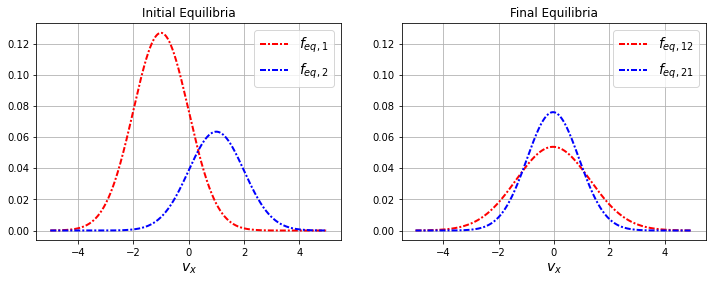

In [11]:
# Plot distribution of species 1 and 2 at their initial and mixed equilibrium states

def Feq_ij(sp, n=n, m=m, kB=kB, T_mixed=T_mixed, u_mixed=u_mixed):
    """
    Args:
    ===
    sp: i-th species
    n: number density
    m: mass
    kB: Boltzmann's constant
    T_mixed: temperature of mixed
    u_mixed: mean velocity of mixed
    v: velocity
    
    Output:
    ===
    Computes equilibrium distribution function for species sp = 1, 2. Returns value at given velocity v.
    """
    if sp not in [1,2]:
        print("ERROR: Invalid species index.")
    
    def compute_Feq_ij(v):
        return n[sp-1] * ((m[sp-1] / (2*np.pi*kB*T_mixed))**1.5) * np.exp(-(m[sp-1]*two_norm_sq(v-u_mixed)) / (2*kB*T_mixed))
    
    return compute_Feq_ij

feq1 = Feq([alpha1, -beta1, gamma1])
feq2 = Feq([alpha2, beta2, gamma2])
v_sim = v_list.copy()
v_sim[:, 1] = 0
v_sim[:, 2] = 0
v_x = v_sim[:, 0]
v_x.sort()

feq1_list = list(map(feq1, v_sim))
feq2_list = list(map(feq2, v_sim))

feq12_list = list(map(Feq_ij(1), v_sim))
feq21_list = list(map(Feq_ij(2), v_sim))

plt.figure(figsize=(12,4))

ax0 = plt.subplot(1,2,1)
plt.plot(v_x, feq1_list, ls=(0,(3,1,1,1)), color="red", lw=2, label="$f_{eq,1}$")
plt.plot(v_x, feq2_list, ls=(0,(3,1,1,1)), color="blue", lw=2, label="$f_{eq,2}$")
plt.grid()
plt.legend(fontsize=14)
plt.title("Initial Equilibria")
plt.xlabel("$v_{x}$", fontsize=14)

plt.subplot(1,2,2,sharey=ax0)
plt.plot(v_x, feq12_list, ls=(0,(3,1,1,1)), color="red", lw=2, label="$f_{eq,12}$")
plt.plot(v_x, feq21_list, ls=(0,(3,1,1,1)), color="blue", lw=2, label="$f_{eq,21}$")
plt.grid()
plt.legend(fontsize=14)
plt.title("Final Equilibria")
plt.xlabel("$v_{x}$", fontsize=14)

plt.show()

# Simulation of the collision

In [12]:
# Define functions for simulation
    
def run_sim(colfreq=colfreq, mixed_f=Feq_ij, indv_f=f_init, v_sim=v_sim, itr=10):
    """
    Args:
    ===
    colfreq: collision frequencies
    mixed_f: distribution function for mixed
    indv_f: distribution function for individual
    v_sim: velocity grid with the second and third components of each velocity zeroed out
    itr: number of iterations
    
    Output:
    ===
    Returns plots of the evolution of the distribution functions.
    """
    plt.figure(figsize=(12,14))
    plt.subplots_adjust(hspace=.5)
    
    for sp in [1,2]:
        color = ["red" if sp==1 else "blue"][0]
        f = indv_f(sp)
        Feq = mixed_f(sp)

        init = np.array(list(map(f, v_sim)))
        mixed = np.array(list(map(Feq, v_sim)))

        ax0 = plt.subplot(3,2,1)
        plt.plot(v_x, feq1_list, ls=(0,(1,7)), color="grey", lw=1)
        plt.plot(v_x, feq2_list, ls=(0,(1,7)), color="grey", lw=1)
        plt.plot(v_x, feq12_list, ls=(0,(10,5)), color="grey", lw=1)
        plt.plot(v_x, feq21_list, ls=(0,(10,5)), color="grey", lw=1)
        plt.plot(v_x, init, label=f"$f_{sp}$", color=color)
        plt.title("0 timesteps")
        plt.xlabel("$v_{x}$", fontsize=14)
        plt.legend(fontsize=14)
        plt.grid(visible=True)
        
        val = init
        count = 1
        for i in range(1, itr+1):
            val += colfreq[sp-1]*(init-val) + colfreq[-1]*(mixed-val)
            if i%2 == 0:
                count += 1
                plt.subplot(3,2,count,sharey=ax0)
                plt.plot(v_x, feq1_list, ls=(0,(1,7)), color="grey", lw=1)
                plt.plot(v_x, feq2_list, ls=(0,(1,7)), color="grey", lw=1)
                plt.plot(v_x, feq12_list, ls=(0,(10,5)), color="grey", lw=1)
                plt.plot(v_x, feq21_list, ls=(0,(10,5)), color="grey", lw=1)
                plt.plot(v_x, val, label=f"$f_{sp}$", color=color)
                plt.title(f"{i} timesteps")
                plt.xlabel("$v_{x}$", fontsize=14)
                plt.legend(fontsize=14)
                plt.grid(visible=True)
    return

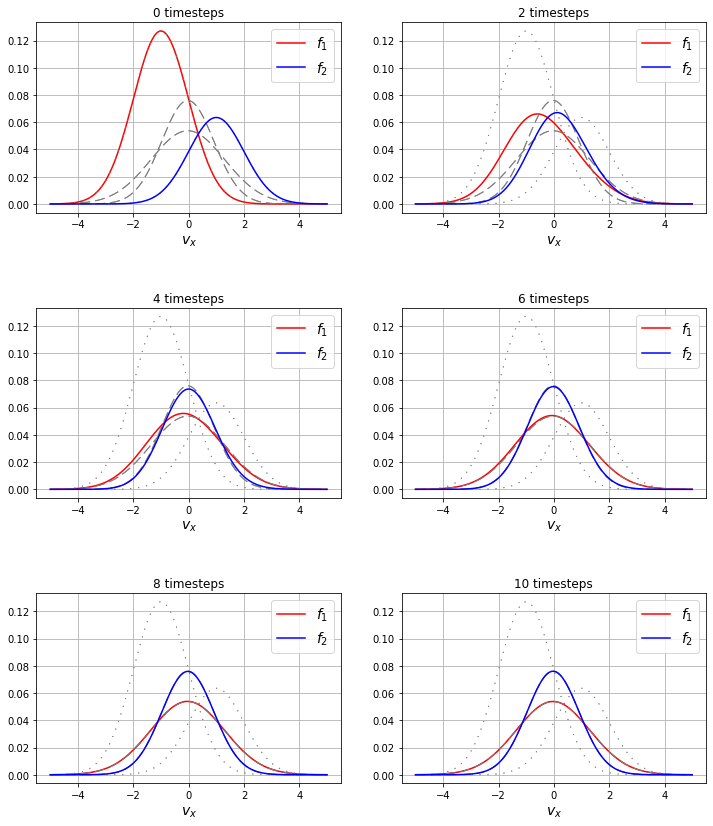

In [13]:
# run simulation

run_sim()

---